In [10]:
# Necessary imports

import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
#from qiskit_machine_learning.utils import algorithm_globals
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

# Set seed for random generators
#algorithm_globals.random_seed = 42

In [11]:
# Additional torch-related imports
import torch
from torch import cat, no_grad, manual_seed
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    NLLLoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
)
import torch.nn.functional as F
import numpy as np

In [12]:
from qiskit.primitives import Estimator

estimator = Estimator()

# MNIST & FashionMNIST

In [13]:
# # Train Dataset
# # -------------

# # Set train shuffle seed (for reproducibility)
# manual_seed(42)

# batch_size = 64
# n_samples = 1024  # We will concentrate on the first 100 samples

# # Use pre-defined torchvision function to load MNIST train data
# X_train = datasets.FashionMNIST(
#     root="./data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()])
# )

# # Filter out labels (originally 0-9), leaving only labels 0 and 1
# idx = np.append(
#     np.where(X_train.targets == 0)[0][:n_samples], np.where(X_train.targets == 1)[0][:n_samples]
# )
# X_train.data = X_train.data[idx]
# X_train.targets = X_train.targets[idx]

# # Define torch dataloader with filtered data
# train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True)

In [14]:
# n_samples_show = 6

# data_iter = iter(train_loader)
# fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

# while n_samples_show > 0:
#     images, targets = data_iter.__next__()

#     axes[n_samples_show - 1].imshow(images[0, 0].numpy().squeeze(), cmap="gray")
#     axes[n_samples_show - 1].set_xticks([])
#     axes[n_samples_show - 1].set_yticks([])
#     axes[n_samples_show - 1].set_title("Labeled: {}".format(targets[0].item()))

#     n_samples_show -= 1

In [15]:
# n_samples = 512

# # Use pre-defined torchvision function to load MNIST test data
# X_test = datasets.FashionMNIST(
#     root="./data", train=False, download=True, transform=transforms.Compose([transforms.ToTensor()])
# )

# # Filter out labels (originally 0-9), leaving only labels 0 and 1
# idx = np.append(
#     np.where(X_test.targets == 0)[0][:n_samples], np.where(X_test.targets == 1)[0][:n_samples]
# )
# X_test.data = X_test.data[idx]
# X_test.targets = X_test.targets[idx]

# # Define torch dataloader with filtered data
# test_loader = DataLoader(X_test, batch_size=batch_size, shuffle=True)

In [16]:
# CIFAR10

In [17]:
# Set random seed for reproducibility
manual_seed(42)

# Hyperparameters
batch_size = 64
n_samples = 1024  # Number of samples per class

# Load MNIST dataset
X_train = datasets.CIFAR10(
    root="./data", 
    train=True, 
    download=True, 
    transform=transforms.Compose([transforms.ToTensor()])
)

# Convert targets to NumPy array for easier indexing
targets_np = np.array(X_train.targets)

# Filter indices for labels 0 and 1
label_0_idx = np.where(targets_np == 0)[0][:n_samples]  # Indices for label 0
label_1_idx = np.where(targets_np == 1)[0][:n_samples]  # Indices for label 1

# Combine indices
idx = np.concatenate([label_0_idx, label_1_idx])

# Filter data and targets
X_train.data = X_train.data[idx]
X_train.targets = targets_np[idx].tolist()  # Convert back to list for compatibility

# Create DataLoader
train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


In [18]:
# Set random seed for reproducibility
manual_seed(42)

# Hyperparameters
batch_size = 64
n_samples = 512  # Number of samples per class

# Load MNIST dataset
X_test = datasets.CIFAR10(
    root="./data", 
    train=False, 
    download=True, 
    transform=transforms.Compose([transforms.ToTensor()])
)

# Convert targets to NumPy array for easier indexing
targets_np = np.array(X_test.targets)

# Filter indices for labels 0 and 1
label_0_idx = np.where(targets_np == 0)[0][:n_samples]  # Indices for label 0
label_1_idx = np.where(targets_np == 1)[0][:n_samples]  # Indices for label 1

# Combine indices
idx = np.concatenate([label_0_idx, label_1_idx])

# Filter data and targets
X_test.data = X_test.data[idx]
X_test.targets = targets_np[idx].tolist()  # Convert back to list for compatibility

# Create DataLoader
test_loader = DataLoader(X_test, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


In [19]:
def create_qnn():
    feature_map = ZZFeatureMap(4)
    ansatz = RealAmplitudes(4, reps=1)
    qc = QuantumCircuit(4)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = EstimatorQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
        estimator=estimator,
    )
    return qnn


qnn4 = create_qnn()

In [20]:
class Net(Module):
    def __init__(self, qnn):
        super().__init__()
        self.conv1 = Conv2d(3, 2, kernel_size=5)
        self.conv2 = Conv2d(2, 16, kernel_size=5)
        self.dropout = Dropout2d()
        self.fc1 = Linear(400, 64)
        self.fc2 = Linear(64, 4)  # 2-dimensional input to QNN
        self.qnn = TorchConnector(qnn)  # Apply torch connector, weights chosen
        # uniformly at random from interval [-1,1].
        self.fc3 = Linear(1, 1)  # 1-dimensional output from QNN

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.qnn(x)  # apply QNN
        x = self.fc3(x)
        return cat((x, 1 - x), -1)


model4 = Net(qnn4)

In [21]:
# Define model, optimizer, and loss function
optimizer = optim.Adam(model4.parameters(), lr=0.001)
loss_func = NLLLoss()

# Start training
epochs = 50  # Set number of epochs
loss_list = []  # Store loss history
model4.train()  # Set model to training mode

for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        output = model4(data)  # Forward pass
        loss = loss_func(output, target)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize weights
        total_loss.append(loss.item())  # Store loss
    loss_list.append(sum(total_loss) / len(total_loss))
    torch.save(model4.state_dict(), "model4.pt")
    print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))

Training [2%]	Loss: -0.5050
Training [4%]	Loss: -0.5385
Training [6%]	Loss: -0.6186
Training [8%]	Loss: -0.7026
Training [10%]	Loss: -0.7744
Training [12%]	Loss: -0.8217
Training [14%]	Loss: -0.8675
Training [16%]	Loss: -0.9025
Training [18%]	Loss: -0.9386
Training [20%]	Loss: -0.9736
Training [22%]	Loss: -0.9878
Training [24%]	Loss: -1.0280
Training [26%]	Loss: -1.0945
Training [28%]	Loss: -1.1181
Training [30%]	Loss: -1.1302
Training [32%]	Loss: -1.1778
Training [34%]	Loss: -1.1939
Training [36%]	Loss: -1.2611
Training [38%]	Loss: -1.2723
Training [40%]	Loss: -1.2918
Training [42%]	Loss: -1.3103
Training [44%]	Loss: -1.3729
Training [46%]	Loss: -1.3986
Training [48%]	Loss: -1.4296
Training [50%]	Loss: -1.4650
Training [52%]	Loss: -1.4933
Training [54%]	Loss: -1.5235
Training [56%]	Loss: -1.5660
Training [58%]	Loss: -1.6244
Training [60%]	Loss: -1.6299
Training [62%]	Loss: -1.6938
Training [64%]	Loss: -1.7351
Training [66%]	Loss: -1.7478
Training [68%]	Loss: -1.7675
Training [70%]	Los

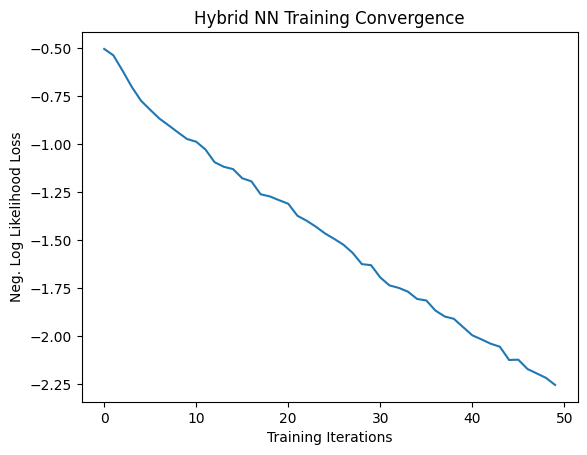

In [22]:
# Plot loss convergence
plt.plot(loss_list)
plt.title("Hybrid NN Training Convergence")
plt.xlabel("Training Iterations")
plt.ylabel("Neg. Log Likelihood Loss")
plt.show()

In [23]:
qnn5 = create_qnn()
model5 = Net(qnn5)
model5.load_state_dict(torch.load("model4.pt"))

<All keys matched successfully>

In [24]:
model5.eval()  # set model to evaluation mode
with no_grad():

    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model5(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = loss_func(output, target)
        total_loss.append(loss.item())

    print(
        "Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%".format(
            sum(total_loss) / len(total_loss), correct / len(test_loader) / batch_size * 100
        )
    )

Performance on test data:
	Loss: -2.1980
	Accuracy: 83.8%


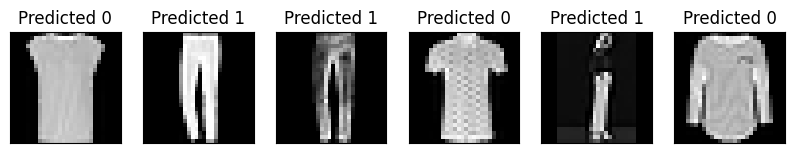

In [71]:
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model5.eval()
with no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model5(data[0:1])
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)

        axes[count].imshow(data[0].numpy().squeeze(), cmap="gray")

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title("Predicted {}".format(pred.item()))

        count += 1